## Illustrative Code for "Interpreting Feature Importance in Wavelet-Based Deep Learning for Multi-Time Scale Affect Forecasting"

This code produces the plots and estimation results for illustration III reported in:

Chow, Cho, Xiong, Li, Shen, Das, Ji, & Kumara (2025, submitted). Interpreting Feature Importance in Wavelet-Based Deep Learning for Multi-Time Scale Affect Forecasting. Proceedings of the International Meeting of the Psychometric Society.

In this illustration, we generated time series data for 15 hypothetical participants contaminated with Gaussian noise, as dependent on three (features 4-6) out of 6 possible features that comprised structured sinusoidal signals during specific time spans. We tested the proposed procedures of splitting of the 15 participants into a training set and a test set, and optimization of the hyperparameters through Hyperopt over 15 trials with 30 epochs each. Following the estimation procedures, we plotted the weighted activation map to depict the importance of the 6 features, 3 of which were spurious.


First we load some packages and define some functions that we are going to use.

In [19]:
import os
import sys
import gc
import random
#import pandas as pd

import matplotlib.pyplot as plt
import importlib
import seaborn as sns
import numpy as np
import shap

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK,space_eval
from hyperopt.pyll.base import scope

#from sklearn.model_selection import GroupKFold
#from sklearn.model_selection import KFold
#from sklearn.model_selection import train_test_split


from sklearn.model_selection import train_test_split
from tensorflow.keras.mixed_precision import set_global_policy

import myTVFunctions
importlib.reload(myTVFunctions)

from myTVFunctions import *


# Verify TensorFlow version and GPU availability
print("TensorFlow version:", tf.__version__)
print("Python version:", sys.version)
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.list_physical_devices())
tf.debugging.set_log_device_placement(False)

print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))
print(tf.sysconfig.get_build_info())
tf.keras.backend.clear_session()
gc.collect()

fig_path = "C:/Users/symii/Dropbox/MachineLearning/Kymatio/ADID_Lab/IMPS_Proceedings2024/Manuscript/ScatterT_AffectForecast_IMPSProc2025/Figures/"

TensorFlow version: 2.10.0
Python version: 3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:07:43) [MSC v.1942 64 bit (AMD64)]
Num GPUs Available: 1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
OrderedDict([('cpu_compiler', 'C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.29.30133/bin/HostX64/x64/cl.exe'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '64_112'), ('cudart_dll_name', 'cudart64_112.dll'), ('cudnn_dll_name', 'cudnn64_8.dll'), ('cudnn_version', '64_8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False), ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll'), ('nvcuda_dll_name', 'nvcuda.dll')])


In [ ]:
seednum=12345
set_seeds(seednum)
# Define the hyperparameter search space

activation_options = ['relu', 'elu']
space_scatter = {
    #'J': scope.int(hp.quniform('J', 2, 6, 1)),
    #'Q': scope.int(hp.quniform('Q', 1, 8, 1)),
    'hidden_dim': scope.int(hp.quniform('hidden_dim', 5, 32, 1)),
    'num_layers': scope.int(hp.quniform('num_layers', 3, 5, 1)), #By default includes at least two layers
    'dropout_rate': hp.uniform('dropout_rate', 0.0, 0.7),
    'activation': hp.choice('activation', range(len(activation_options))),
    'lr': hp.loguniform('lr', -3, -1),
    'l2_reg': hp.loguniform('l2_reg', -3, -1)
    #'lr': hp.loguniform('lr', -5, -3),
    #'l2_reg': hp.loguniform('l2_reg', np.log(1e-5), np.log(2e-1))
}

space_scatter_1layer = {
    #'J': scope.int(hp.quniform('J', 2, 6, 1)),
    #'Q': scope.int(hp.quniform('Q', 1, 8, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.0, 0.7),
    'activation': hp.choice('activation', range(len(activation_options))),
    'lr': hp.loguniform('lr', -3, -1),
    'l2_reg': hp.loguniform('l2_reg', -3, -1)
    #'lr': hp.loguniform('lr', -5, -3),
    #'l2_reg': hp.loguniform('l2_reg', np.log(1e-5), np.log(2e-1))
}

def monte_carlo_simulation(num_MC, num_samples, num_features, num_T, num_epochs, frequencies, noise_std, J, Q, max_evals, test_ratio=.3,
                           is_Debug = False, use_GPU = False, batch_size=100, epochs=100, activation_options=['relu', 'elu'],
                           K=2, isPlot=False, sample_toPlot=0, feature_indices= [0,1,2], model_spec = "flex"):


    stuff = pd.DataFrame([{'num_samples': num_samples,
            'num_T': num_T,
            'k_folds': K,
            'test_ratio':test_ratio,
            'epochs': epochs,
            'batch_size': batch_size}])
    FlexScatterFile = f"../../Results/TVFreq/Scatter_n{num_samples}_T{num_T}_K{K}_test_ratio_{test_ratio}.csv"
    
    for i in range(0,num_MC):
        print("Good day!, this is run: ", i)
        # [1] Generate data
        run = pd.DataFrame([{'run': i}])
        Xsim, ysim = generateTVFreq_Data(num_samples, num_features, num_T, frequencies, amplitude, noise_std)

        ysim = ysim.reshape(num_samples, 1, num_T)
        print("Xsim shape:", Xsim.shape)  #Xsim shape: (num_samples, num_features, num_T)
        print("ysim shape:", ysim.shape)  #ysim shape: (num_samples, output_dim, num_T)

        LossesbyFold = dict()
        R2byFold = dict()
        bestParams = dict()
        
        if (isPlot):
            
        # Create the time series plot
            num_features_to_plot=len(feature_indices)
            fig, axes = plt.subplots(num_features_to_plot + 1, 1, figsize=(12, 2 * num_features_to_plot), sharex=True)

            for i, feature_idx in enumerate(feature_indices):
                ax = axes[i] if num_features_to_plot > 1 else axes  # Handle single feature case
                ax.plot(range(Xsim.shape[2]), Xsim[sample_toPlot, feature_idx, :], 
                        label=f"Feature {feature_idx+1}", color='b')
                ax.set_ylabel(f"Feature {feature_idx+1}")
                ax.legend(loc="upper right")

            axes[-1].set_xlabel("Time")  # Set x-axis label only on the last subplot
            plt.suptitle(f"Last {num_features_to_plot} Features for Sample {sample_toPlot}")
            
            ax = axes[num_features]
            ax.plot(range(ysim.shape[1]), ysim[sample_toPlot,:].reshape(-1), 
                label="y data", color='b')
                
            plt.tight_layout()
            plt.show()

    
        X_in_Train, X_in_Test, Y_data, Y_data2 = train_test_split(Xsim, ysim, test_size=test_ratio, random_state=seednum)
        print("Shape of X_in_Train: ", X_in_Train.shape)
        print("Shape of Y_data: ", Y_data.shape)
        
        #@@@@
        output_dim = Y_data.shape[1] 
        
        #------  Flexible embedding + scattering transform with CV ------#
        trials_flex_scatter = Trials()
        
        if (model_spec == "flex"):
            best_params_cv = fmin(
                fn=lambda params: objective_Flex_Scatter(params, X_in_Train, Y_data, 
                Y_data.shape[1],batch_size, epochs, K, num_T, J, Q,
                is_Debug = is_Debug, use_GPU=use_GPU, activation_options=activation_options, model_spec = model_spec),
                space=space_scatter,
                algo=tpe.suggest,
                max_evals=max_evals,
                trials=trials_flex_scatter
        )
        elif (model_spec == "1layer"):
            best_params_cv = fmin(
                fn=lambda params: objective_Flex_Scatter(params, X_in_Train, Y_data, 
                Y_data.shape[1],batch_size, epochs, K, num_T, J, Q,
                is_Debug = is_Debug, use_GPU=use_GPU, activation_options=activation_options, model_spec = model_spec),
                space=space_scatter_1layer,
                algo=tpe.suggest,
                max_evals=max_evals,
                trials=trials_flex_scatter
        )
        
        best_params_flex_embed_scatter = best_params_cv
        print("best_params_cv: ", best_params_cv)

        if (model_spec == "flex"):
            #scope.int made the returned num_layers a float, as opposed to int. Converting below.
            best_params_flex_embed_scatter['num_layers'] = int(best_params_cv['num_layers'])
            best_params_flex_embed_scatter['hidden_dim'] = int(best_params_cv['hidden_dim'])

            #Create a scattering model
            best_scatterModel = create_scattering_nn(params = best_params_flex_embed_scatter, 
                           num_features = X_in_Train.shape[1],
                           output_dim = Y_data.shape[1], 
                           num_T = num_T, J = J, Q = Q, is_Debug = is_Debug, use_GPU = use_GPU, activation_options=activation_options, is_Plot=False)
        
        elif (model_spec == "1layer"):
            #Create a scattering model
            best_scatterModel = create_scattering_nn_1layer(params = best_params_flex_embed_scatter, 
                           num_features = X_in_Train.shape[1],
                           output_dim = Y_data.shape[1], 
                           num_T = num_T, J = J, Q = Q, is_Debug = is_Debug, use_GPU = use_GPU, activation_options=activation_options, is_Plot=False)
        

           
        saveModelFile = f"../bestModels/TVFreq/Scatter_n{num_samples}_T{num_T}_K{K}_test_ratio_{test_ratio}run_{i+1}.h5"
        
        results, _, _, _, _, Y_data, Y_data2 = evaluate_model(best_scatterModel, 
                X_in_Train, X_in_Test, Y_data, Y_data2, 
                withID = False, batch_size=batch_size, 
                epochs=epochs, is_Debug=is_Debug)

        
        print("Best flex embed with scattering hyperparameters: ", best_params_cv)
        
        #ADD FOLD-LEVEL LOSSES
        # Extract the fold_losses from the trial with the best result
        LossesbyFold['FlexScatter'] = trials_flex_scatter.trials[trials_flex_scatter.best_trial['tid']]['result']['fold_losses']
        R2byFold['FlexScatter'] = trials_flex_scatter.trials[trials_flex_scatter.best_trial['tid']]['result']['R2byFold']
        
        print("Fold losses from the best trial:", LossesbyFold['FlexScatter'])
        print("Fold R2 from the best trial:", R2byFold['FlexScatter'])
        #ADD BEST HYPERPARAMETERS
        bestParams['FlexScatter'] =  best_params_cv
            
        # Extract the fold_losses from the last trial
        #LossesbyFold['lastLossesFlexEmbedScatter'] = trials_flex_scatterEmbed.trials[-1]['result']['fold_losses']
        #print("Fold losses from the last trial:", LossesbyFold['lastLossesFlexEmbedScatter'])


        results_pd4 = pd.concat([run, stuff, dictoDataFrame(results), 
                                rename_and_convert_array(LossesbyFold['FlexScatter'], 
                                                          output_dim , K, "Losses"), 
                                rename_and_convert_array(R2byFold['FlexScatter'],
                                                          output_dim , K, "R2"),  
                                dictoDataFrame(bestParams['FlexScatter']), pd.DataFrame([{'J': J, 'Q':Q}])], axis=1)
        if (is_Debug==True):
                print(results_pd4.head())
                print("Best flex scattering model config: ",best_params_cv)
        best_scatterModel.save(saveModelFile)
        results_pd4.to_csv(FlexScatterFile, mode='a', header=not os.path.exists(FlexScatterFile), index=False, na_rep="NaN")

    
        
    return LossesbyFold, R2byFold, bestParams, best_params_cv, best_scatterModel, X_in_Train, X_in_Test, Y_data, Y_data2


Expected outputs from final model to be used/produced in the creation of the activation map
### **🔍 Expected Output Shapes**
| Variable                  | Shape                                   | Description |
|---------------------------|----------------------------------------|-------------|
| `scattering_activations`  | `(None, num_features * num_ScatteringCoefficients * num_TimeWindows)` | Raw activations |
| `reshaped_scattering_activations` | `(None, num_features, num_ScatteringCoefficients, num_TimeWindows)` | Activations reshaped for element-wise multiplication |
| `importance`              | `(num_features*num_ScatteringCoefficients*num_TimeWindows, output_dim)`                        | First layer weights|
| `importance`              | `(num_features*num_ScatteringCoefficients*num_TimeWindows, output_dim*num_T)`                        | Backpropagated weights |
| `Scattering activations (X_MLP)`| `(None, num_features*num_ScatteringCoefficients*num_TimeWindows, output_dim)` | Scattering activations |
| `Flattened_scattering_activations`         | `(None, num_features*num_ScatteringCoefficients, num_TimeWindows)`  | Scattering activations by frequency band over time windows|
| ` heat_np`   | `(None, num_features, num_T or num_TimeWindows, output_dim)`               | Feature importance (output-weighted scattering activations) for each individual |
| ` heatmap_plot_AllSamples1`   | `(num_features, num_T or num_TimeWindows, output_dim)`               | Feature importance averaged across samples |

---
Example:
* Shape of importance (weight matrix in first layer):  (1152, 1)
* Replicated importance shape: (None, 1152, 1)
* Reshaped replicated importance shape:  (None, 6, 3, 64, 1)
* Shape of scattering_activations:  (None, 1152)
* Shape of reshaped scattering_activations:  (None, 6, 3, 64)
* Num_scattering_coefs: 3; num_TimeWindows: 64
* Shape of weightedActivations:  (None, 6, 64, 1)

use_GPU: True
feature_index:  3
From t = 0 to 256.
feature_index:  4
From t = 172 to 341.
feature_index:  5
From t = 342 to 512.


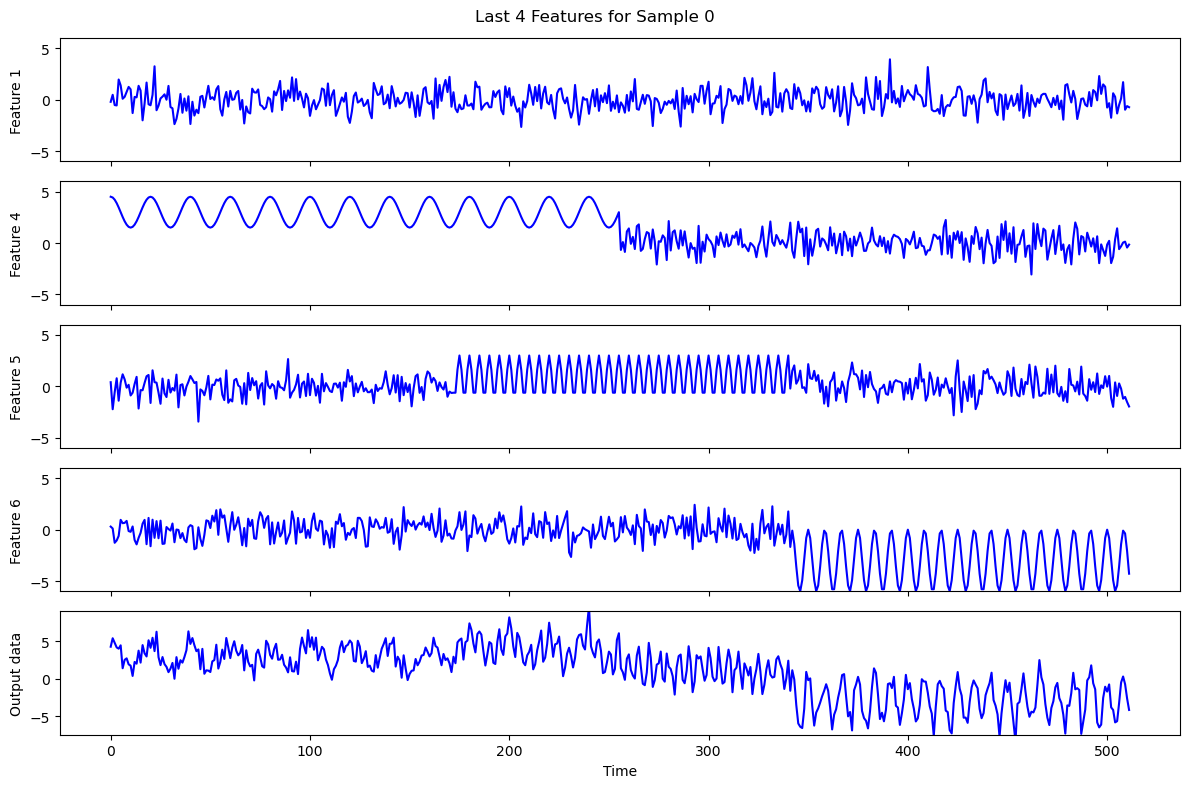

In [ ]:
set_global_policy('mixed_float16')  # Reduce memory footprint


# Initialize parameters
gpus = tf.config.list_physical_devices('GPU')
use_GPU = len(gpus) > 0
print('use_GPU:', use_GPU)
#if (use_GPU):
#    for gpu in gpus:
#        tf.config.experimental.set_memory_growth(gpu, False) #disable memory growth
#        tf.config.experimental.set_virtual_device_configuration(gpu,[]) #clear memory allocation
num_MC=1
num_samples =  15
num_features = 6
num_T = 2**9 #
# Frequencies for the sine waves (one for each important feature)
frequencies = [.05, .2, .12] #[0.5, 1.0, 2.0, 3.0, 4.0]
amplitude = 1 #Amplitude of simulated data
noise_std = 1 # Set the standard deviation for the noise
log_eps = 1e-7 #Small positive constant to use as the min in calling the log function
max_evals = 15 #Max number of evaluations for hyperopt optimization
num_epochs = 30 #Number of epochs for estimating training model coefficients
batch_size = 50
k_folds = 5
J = 3
Q = 3
test_ratio = .5
is_Debug = False

Xsim, ysim = generateTVFreq_Data(num_samples, num_features, num_T, frequencies, amplitude, noise_std)

feature_indices = [0,3,4,5] #range(num_features)
sample_toPlot = 0

# Create the time series plot
num_features_to_plot=len(feature_indices)
fig, axes = plt.subplots(num_features_to_plot + 1, 1, figsize=(12, 2 * num_features_to_plot), sharex=True)

for i, feature_idx in enumerate(feature_indices):
    ax = axes[i] if num_features_to_plot > 1 else axes  # Handle single feature case
    ax.plot(range(Xsim.shape[2]), Xsim[sample_toPlot, feature_idx, :], 
        label=f"Feature {feature_idx+1}", color='b')
    ax.set_ylabel(f"Feature {feature_idx+1}")
    #ax.legend(loc="upper right")
    ax.set_ylim(-6.0, 6.0)  # Change values as needed

axes[-1].set_xlabel("Time")  # Set x-axis label only on the last subplot
plt.suptitle(f"Last {num_features_to_plot} Features for Sample {sample_toPlot}")
            
ax = axes[len(feature_indices)]
ax.plot(range(ysim.shape[1]), ysim[sample_toPlot,:].reshape(-1), label="y data", color='b')
ax.set_ylim(-7.5, 9)
ax.set_ylabel("Output data")
                
plt.tight_layout()
plt.savefig(f"{fig_path}Sim3.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
model_spec = "1layer"
LossesbyFold, R2byFold, bestParams, best_params_cv, best_scatterModel, X_in_Train, X_in_Test, Y_data, Y_data2 = monte_carlo_simulation(num_MC, num_samples, num_features, num_T, num_epochs, frequencies, noise_std, J, Q, max_evals, test_ratio,
                       is_Debug = is_Debug, use_GPU = False, batch_size=batch_size, epochs=num_epochs, activation_options=['relu', 'elu'],
                       K=k_folds, isPlot=False, feature_indices= range(0, num_features), model_spec=model_spec)


Good day!, this is run:  0
feature_index:  3
From t = 0 to 256.
feature_index:  4
From t = 172 to 341.
feature_index:  5
From t = 342 to 512.
Xsim shape: (15, 6, 512)
ysim shape: (15, 1, 512)
Shape of X_in_Train:  (7, 6, 512)
Shape of Y_data:  (7, 1, 512)
1/1 [==============================] - 1s 690ms/step 

r2 fold 1: [0.8725542570059576]                       
Loss fold 1: [2.1138553619384766]                     
1/1 [==============================] - 1s 540ms/step 

r2 fold 2: [0.8577081867609901]                       
Loss fold 2: [2.0885682106018066]                     
1/1 [==============================] - 1s 535ms/step 

r2 fold 3: [0.8378675135708182]                       
Loss fold 3: [1.980970859527588]                      
1/1 [==============================] - 1s 942ms/step 

r2 fold 4: [0.8354018311134319]                       
Loss fold 4: [2.0333383083343506]                     
1/1 [==============================] - 1s 574ms/step 

r2 fold 5: [0.825171457599764

In [6]:
#Create the final scattering model
firstLayer = True #Whether to use the first layer of weights only
if model_spec == "flex":
    best_scatterModel, scattering_activations, num_ScatteringCoefficients, num_TimeWindows, heat = create_scattering_nn(params = best_params_cv, 
                           num_features = X_in_Train.shape[1],
                           output_dim = Y_data.shape[1], 
                           num_T = num_T, J = J, Q = Q, is_Debug = is_Debug, use_GPU = use_GPU, activation_options=activation_options, 
                           is_Plot=True, firstLayer = firstLayer)
elif model_spec == "1layer":
    best_scatterModel, scattering_activations, num_ScatteringCoefficients, num_TimeWindows, heat = create_scattering_nn_1layer(params = best_params_cv, 
                           num_features = X_in_Train.shape[1],
                           output_dim = Y_data.shape[1], 
                           num_T = num_T, J = J, Q = Q, is_Debug = is_Debug, use_GPU = use_GPU, activation_options=activation_options, 
                           is_Plot=True, firstLayer = firstLayer)

best_scatterModel.fit(
            X_in_Train, Y_data, 
            batch_size=batch_size, verbose=0,  
            epochs=num_epochs
            )



Layer names:  Feature_input
Layer names:  lambda_77
Layer names:  flatten_77
Layer names:  Dropout_MLP
Layer names:  Dense_0
Layer names:  Dropout_0
Layer names:  Dense_1
Layer names:  Reshaped_Dense_Final
Shape of importance (weight matrix in first dense layer):  (1152, 1)
num_samples:  KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.int32, name=None), inferred_value=[None], name='tf.__operators__.getitem_1/strided_slice:0', description="created by layer 'tf.__operators__.getitem_1'")
Replicated importance shape: (None, 1152, 1)
Reshaped replicated importance shape:  (None, 6, 3, 64, 1)
Shape of scattering_activations:  (None, 1152)
Shape of reshaped scattering_activations:  (None, 6, 3, 64)
Num_scattering_coefs: 3; num_TimeWindows: 64
Shape of weightedActivations:  (None, 6, 64, 1)


In [ ]:
print("Scattering nn input:", best_scatterModel.input)

scatteringOutput_model1 = tf.keras.Model(inputs=best_scatterModel.input, outputs=scattering_activations)
#Compute scattering activations using model.predict()
scattering_activations_np = scatteringOutput_model1.predict(X_in_Train)

#output_dim = Y_data.shape[1]

heat_model1 = tf.keras.Model(inputs=best_scatterModel.input, outputs=heat)
#Compute weighted activations using model.predict()
heat_np = heat_model1.predict(X_in_Train)

print("Shape of heat: ", heat_np.shape)

# Compute mean after converting to NumPy
#if (firstLayer == True):
heatmap_plot_AllSamples1 = np.mean(heat_np[:,:,:,0], axis=0)  # Shape: (num_features, num_T or num_TimeWindows)
#elif(firstLayer == False):
#    heatmap_plot_AllSamples1 = np.mean(heat_np[:,:,0,:], axis=0)  # Shape: (num_features, num_T)
print("Shape of heatmap_feature 1: ", heat_np.shape)
print("Shape of heatmap_plot1 across all samples: ", heatmap_plot_AllSamples1.shape)

#Compute scattering activations using model.predict()
scattering_activations = scatteringOutput_model1.predict(X_in_Train)
print("Predicted scattering activations shape:", scattering_activations.shape)

Reshaped_scattering_activations = scattering_activations.reshape(X_in_Train.shape[0], num_features, num_ScatteringCoefficients, num_TimeWindows)
print("Reshaped scattering activations shape:", Reshaped_scattering_activations.shape)

Flattened_scattering_activations = np.mean(scattering_activations.reshape(X_in_Train.shape[0], 
                                           num_features*num_ScatteringCoefficients, num_TimeWindows), axis=0)

Max_scattering_activations = np.mean(np.max(Reshaped_scattering_activations, axis=2), axis=0)


Scattering nn input: KerasTensor(type_spec=TensorSpec(shape=(None, 6, 512), dtype=tf.float32, name='Feature_input'), name='Feature_input', description="created by layer 'Feature_input'")
1/1 [==============================] - 1s 1s/step
Shape of heat:  (7, 6, 64, 1)
Shape of heatmap_feature 1:  (7, 6, 64, 1)
Shape of heatmap_plot1 across all samples:  (6, 64)
1/1 [==============================] - 0s 50ms/step
Predicted scattering activations shape: (7, 1152)
Reshaped scattering activations shape: (7, 6, 3, 64)


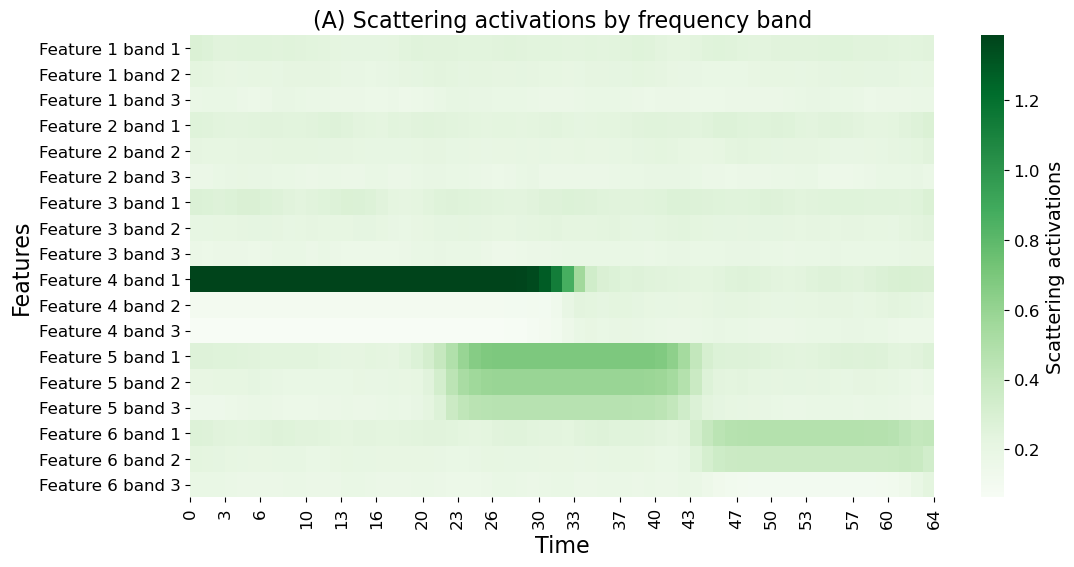

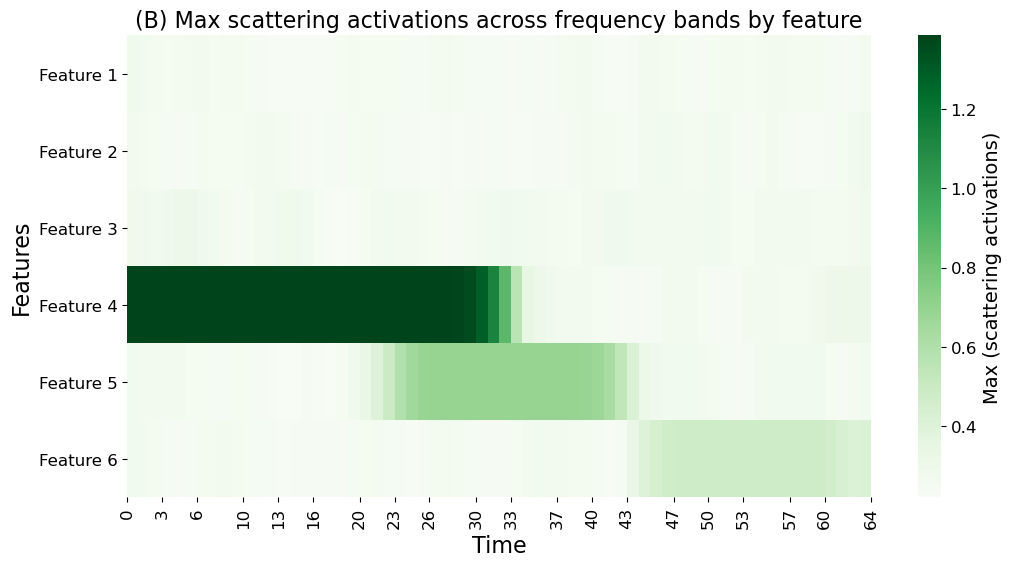

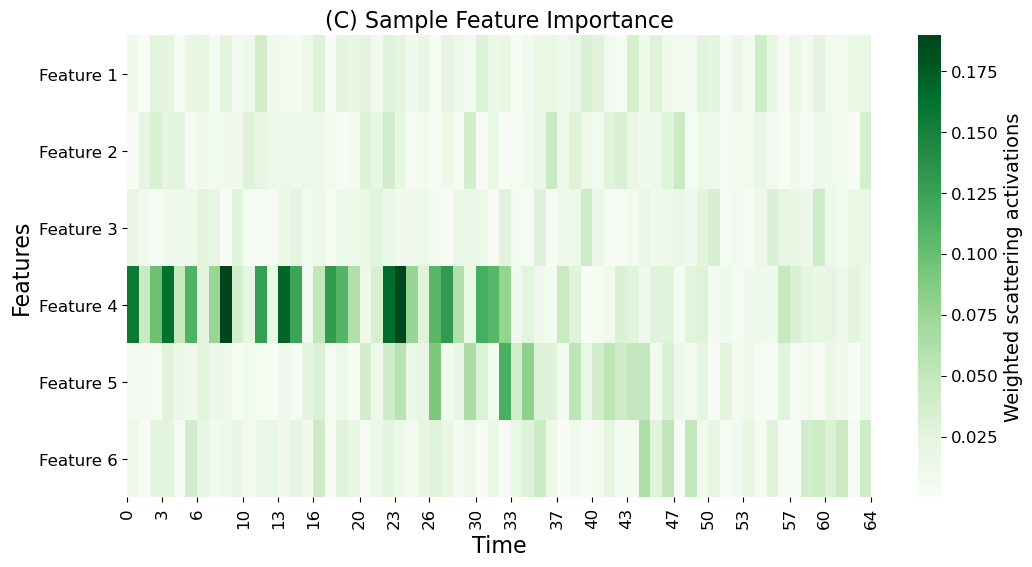

In [22]:
#Call function in myTVFunctions.py

#This is now identical to Max_Scattering_activaitions since the max operation was already taken inside the scattering model
create_and_save_activationMap(Flattened_scattering_activations, num_features*num_ScatteringCoefficients,
                         colors="Greens", barLabel = "Scattering activations",
                         ylabels= [f"Feature {f+1} band {b+1}" for f in range(num_features) for b in range(3)],
                         title="(A) Scattering activations by frequency band", saveFile = f"{fig_path}Sim3A.pdf")

create_and_save_activationMap(Max_scattering_activations, num_features,
                         ylabels=[f"Feature {i+1}" for i in range(0,num_features)],
                         colors="Greens", barLabel = "Max (scattering activations)",
                         title="(B) Max scattering activations across frequency bands by feature", saveFile = f"{fig_path}Sim3B.pdf")

create_and_save_activationMap(heatmap_plot_AllSamples1, num_features,
                        ylabels=[f"Feature {i+1}" for i in range(0,num_features)],
                         colors="Greens", barLabel = "Weighted scattering activations",
                         title="(C) Sample Feature Importance", saveFile = f"{fig_path}Sim3C.pdf")